In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from numba import jit, autojit
from scipy.sparse import csc_matrix, dia_matrix, diags
from scipy.sparse.linalg import eigs, eigsh

x = np.linspace(-10,10,1001)

In [3]:
# Initialise constants for the softcore potential:
v = 20# set =0 for particle in a box case
n = 2
b = 2


@np.vectorize
def potential(xk, t):
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator


def gen_diag_Hamiltonian(x_arr):
    
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    V = potential(x_arr, t)
    
    centre_diag = V - (5/2)*dx2
    one_off_diag = (4/3)*np.ones_like(x_arr[:-1])*dx2    
    two_off_diag = -(1/12)*np.ones_like(x_arr[:-2])*dx2
    
    H = diags([centre_diag,one_off_diag,one_off_diag,two_off_diag,two_off_diag],[0,1,-1,2,-2])
    return H

H = gen_diag_Hamiltonian(x)


biggest_abs_val = 550
eig_vals,eig_vecs = eigsh(H, k=5, sigma=-biggest_abs_val)

In [43]:
dt = 1e-3

@jit
def time_evo_operator(eig_val, t):
    return np.exp(-1j*eig_val*t)

original_eigstate = eig_vecs[:,1]

evolve_o_eigstate_no_ext_n_times = lambda n: [original_eigstate * time_evo_operator(eig_vals[0], dt)**i for i in range(0,n)]

"""
6th order time propogation results:
"""

sixth_order_coeffs = np.array([-49/20, 6, -15/2, 20/3, -15/4, 6/5, -1/6])/dt

@autojit
def evolve_state(dt, previous_eigstates, coeffs):
    evolved_part = (H*previous_eigstates[-1])
    new_eigstate = 1j*dt*evolved_part
    for i,c in enumerate(coeffs[1:]):
        new_eigstate -= c*previous_eigstates[-i-1]
    new_eigstate /= coeffs[0]
    return new_eigstate

previous_eigstates = evolve_o_eigstate_no_ext_n_times(6)
#print(previous_eigstates[0][4995:5005])

def time_step():
    global previous_eigstates
    new_eigstate = evolve_state(dt, previous_eigstates, sixth_order_coeffs)
    previous_eigstates.append(new_eigstate)
    del previous_eigstates[0]



<IPython.core.display.Javascript object>


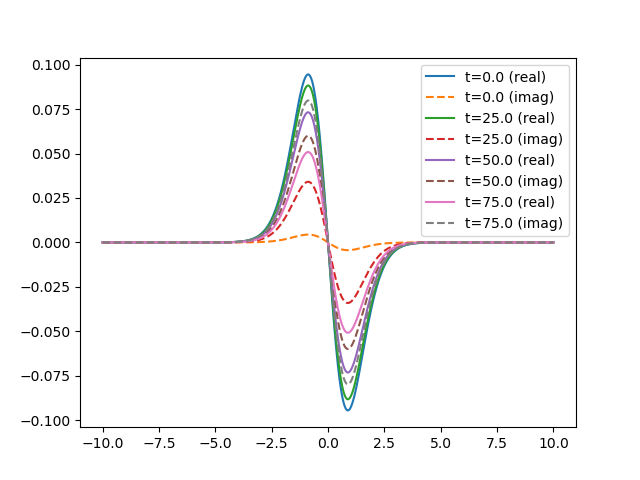

In [44]:
plt.figure()
for i in range(4):
    plt.plot(x, previous_eigstates[-1].real, label='t={} (real)'.format(i*25000*dt))
    plt.plot(x, previous_eigstates[-1].imag, '--', label='t={} (imag)'.format(i*25000*dt))
    for j in range(40000):
        time_step()
    plt.legend(loc=1)

In [27]:
@np.vectorize
def potential_linear_with_time(xk, t):
    alpha = 0.05
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator + alpha*t*xk

@np.vectorize
def potential_oscillating_with_time(xk,t):
    omega = 50
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator + np.sin(t*omega)*xk




'\nNEXT PART:\n\n@np.vectorize\ndef potential_linear_with_time(xk, t):\n    alpha = 0.05\n    numerator = -v\n    denominator = (np.abs(xk)**n + b**n)**(1/n)\n    return numerator/denominator + alpha*t*xk\n\n@np.vectorize\ndef potential_oscillating_with_time(xk,t):\n    omega = 50\n    numerator = -v\n    denominator = (np.abs(xk)**n + b**n)**(1/n)\n    return numerator/denominator + np.sin(t*omega)*xk\n'